从pickle中获取删除了空行空列的数据

In [9]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

with open('../data/data_remove_empty.pkl', 'rb') as file:
    data = pickle.load(file)

data

,,HIS出院科室,住院号码,病床号,病人姓名,入院时间,出院时间,采集时间,钾,钠,...,白介素8,白介素8 1,白介素10,白介素10 1,白介素17A,白介素17A 1,肿瘤坏死因子α,肿瘤坏死因子α 1,干扰素γ,干扰素γ 1
0,1,内分泌代谢科,372320,2007,cai hui bin,2022-01-20 18:41:00,2022-01-26 09:07:00,2022-01-20 19:38:19,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,内分泌代谢科,372320,2007,cai hui bin,2022-01-20 18:41:00,2022-01-26 09:07:00,2022-01-21 05:35:26,3.93,132.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,内分泌代谢科,372320,2007,cai hui bin,2022-01-20 18:41:00,2022-01-26 09:07:00,2022-01-21 05:35:28,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,内分泌代谢科,372320,2007,cai hui bin,2022-01-20 18:41:00,2022-01-26 09:07:00,2022-01-21 05:35:51,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,内分泌代谢科,372320,2007,cai hui bin,2022-01-20 18:41:00,2022-01-26 09:07:00,2022-01-21 05:35:52,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27346,27353,日间病房,463319,6B08,JESSIE MINHUA CHEN,2024-05-30 09:39:00,2024-05-31 13:46:00,2024-05-30 10:25:52,3.92,143.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27347,27354,日间病房,463319,6B08,JESSIE MINHUA CHEN,2024-05-30 09:39:00,2024-05-31 13:46:00,2024-05-30 10:25:58,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27348,27355,日间病房,463319,6B08,JESSIE MINHUA CHEN,2024-05-30 09:39:00,2024-05-31 13:46:00,2024-05-30 10:45:52,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27349,27356,日间病房,463319,6B08,JESSIE MINHUA CHEN,2024-05-30 09:39:00,2024-05-31 13:46:00,2024-05-30 10:45:53,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


数据中有特殊符号，它们在医学中的含义分别是：
- <X: 表示低于实验室检测下限
- \>X: 表示高于实验室检测上限
- ?X: 表示检测结果存疑

要把数据喂给数值模型，必须把它们转换为数值类型，考虑到这些数据的占比非常小，对它们分别的处理方式是：
- <X: 用X/$\sqrt{2}$替代
- \>X: 用X*1.1替代
- ?X: 移除?，暂时接受不可靠的数据

In [10]:
for col in data.iloc[:, 8:].columns:
    if data[col].dtype == 'object':
        data[col] = data[col].astype(str).str.replace(r'<(\d+\.?\d*)', lambda m: str(float(m.group(1)) / np.sqrt(2)),
                                                      regex=True)
        data[col] = data[col].astype(str).str.replace(r'>(\d+\.?\d*)', lambda m: str(float(m.group(1)) * 1.1),
                                                      regex=True)
        data[col] = data[col].astype(str).str.replace(r'\?(\d+\.?\d*)', lambda m: m.group(1), regex=True)
        data[col] = pd.to_numeric(data[col], errors='coerce')
data

,,HIS出院科室,住院号码,病床号,病人姓名,入院时间,出院时间,采集时间,钾,钠,...,白介素8,白介素8 1,白介素10,白介素10 1,白介素17A,白介素17A 1,肿瘤坏死因子α,肿瘤坏死因子α 1,干扰素γ,干扰素γ 1
0,1,内分泌代谢科,372320,2007,cai hui bin,2022-01-20 18:41:00,2022-01-26 09:07:00,2022-01-20 19:38:19,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,内分泌代谢科,372320,2007,cai hui bin,2022-01-20 18:41:00,2022-01-26 09:07:00,2022-01-21 05:35:26,3.93,132.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,内分泌代谢科,372320,2007,cai hui bin,2022-01-20 18:41:00,2022-01-26 09:07:00,2022-01-21 05:35:28,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,内分泌代谢科,372320,2007,cai hui bin,2022-01-20 18:41:00,2022-01-26 09:07:00,2022-01-21 05:35:51,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,内分泌代谢科,372320,2007,cai hui bin,2022-01-20 18:41:00,2022-01-26 09:07:00,2022-01-21 05:35:52,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27346,27353,日间病房,463319,6B08,JESSIE MINHUA CHEN,2024-05-30 09:39:00,2024-05-31 13:46:00,2024-05-30 10:25:52,3.92,143.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27347,27354,日间病房,463319,6B08,JESSIE MINHUA CHEN,2024-05-30 09:39:00,2024-05-31 13:46:00,2024-05-30 10:25:58,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27348,27355,日间病房,463319,6B08,JESSIE MINHUA CHEN,2024-05-30 09:39:00,2024-05-31 13:46:00,2024-05-30 10:45:52,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27349,27356,日间病房,463319,6B08,JESSIE MINHUA CHEN,2024-05-30 09:39:00,2024-05-31 13:46:00,2024-05-30 10:45:53,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


有些列列名相同，比如甘油三酯 甘油三酯1，其实是实验室中同一样本重复测量的结果，可以聚合成平均值。
葡萄糖1 2 3可能是不同时间测的同一个指标葡萄糖，葡萄糖实际指空腹血糖，它可以是葡萄糖1 2 3的任意一个，意图可能是多次测量避免血糖的波动，因此可以将葡萄糖1 2 3删去。甲状旁腺激素（pg/ml）1其实是甲状旁腺激素同一个值的不同计量方式，我们可以把它直接删除。

In [11]:
data_rem_dup = data.copy()

merge_map = {
    '游离三碘甲状腺原氨酸': ['游离三碘甲状腺原氨酸', '游离三碘甲状腺原氨酸1'],
    '碱性磷酸酶': ['碱性磷酸酶', '碱性磷酸酶1'],
    '甲状旁腺激素': ['甲状旁腺激素', '甲状旁腺激素1'],
    '降钙素': ['降钙素', '降钙素1', '降钙素2'],
    '总胆红素': ['总胆红素', '总胆红素1'],
    '维生素B12': ['维生素B12', '维生素B12 1'],
    '白介素1β': ['白介素1β', '白介素1β 1'],
    '白介素2': ['白介素2', '白介素2 1'],
    '白介素4': ['白介素4', '白介素4 1'],
    '白介素5': ['白介素5', '白介素5 1'],
    '白介素6': ['白介素6', '白介素6 1'],
    '白介素8': ['白介素8', '白介素8 1'],
    '白介素10': ['白介素10', '白介素10 1'],
    '白介素17A': ['白介素17A', '白介素17A 1'],
    '肿瘤坏死因子α': ['肿瘤坏死因子α', '肿瘤坏死因子α 1'],
    '干扰素γ': ['干扰素γ', '干扰素γ 1'],
    '25-羟基维生素D': ['25-羟基维生素D', '25-羟基维生素D1', '25-羟基维生素D2'],
}

# 执行合并
for target_col, cols in merge_map.items():
    existing_cols = [col for col in cols if col in data_rem_dup.columns]
    if len(existing_cols) > 1:
        data_rem_dup[target_col] = data_rem_dup[existing_cols].mean(axis=1, skipna=True)
        drop_cols = [col for col in existing_cols if col != target_col]
        data_rem_dup.drop(columns=drop_cols, inplace=True)

# 删除多余列
for col in ['葡萄糖1', '葡萄糖2', '葡萄糖3', '甲状旁腺激素（pg/ml）1']:
    if col in data_rem_dup.columns:
        data_rem_dup.drop(columns=col, inplace=True)

# 将带1后缀的列改名
data_rem_dup.rename(columns=lambda col: col.rstrip('1') if col in ['甘油三酯1', 'C肽1'] else col, inplace=True)

# 保留第8列以后的检测指标
value_data = data_rem_dup.iloc[:, 8:]

data_rem_dup.to_pickle('../data/data_remove_dup.pkl')

data_rem_dup

,,HIS出院科室,住院号码,病床号,病人姓名,入院时间,出院时间,采集时间,钾,钠,...,白介素2,白介素2受体,白介素4,白介素5,白介素6,白介素8,白介素10,白介素17A,肿瘤坏死因子α,干扰素γ
0,1,内分泌代谢科,372320,2007,cai hui bin,2022-01-20 18:41:00,2022-01-26 09:07:00,2022-01-20 19:38:19,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,内分泌代谢科,372320,2007,cai hui bin,2022-01-20 18:41:00,2022-01-26 09:07:00,2022-01-21 05:35:26,3.93,132.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,内分泌代谢科,372320,2007,cai hui bin,2022-01-20 18:41:00,2022-01-26 09:07:00,2022-01-21 05:35:28,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,内分泌代谢科,372320,2007,cai hui bin,2022-01-20 18:41:00,2022-01-26 09:07:00,2022-01-21 05:35:51,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,内分泌代谢科,372320,2007,cai hui bin,2022-01-20 18:41:00,2022-01-26 09:07:00,2022-01-21 05:35:52,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27346,27353,日间病房,463319,6B08,JESSIE MINHUA CHEN,2024-05-30 09:39:00,2024-05-31 13:46:00,2024-05-30 10:25:52,3.92,143.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27347,27354,日间病房,463319,6B08,JESSIE MINHUA CHEN,2024-05-30 09:39:00,2024-05-31 13:46:00,2024-05-30 10:25:58,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27348,27355,日间病房,463319,6B08,JESSIE MINHUA CHEN,2024-05-30 09:39:00,2024-05-31 13:46:00,2024-05-30 10:45:52,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27349,27356,日间病房,463319,6B08,JESSIE MINHUA CHEN,2024-05-30 09:39:00,2024-05-31 13:46:00,2024-05-30 10:45:53,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


这份数据的稀疏性是有道理的，因为医生会根据初步诊断决定要给病人检测什么指标，特征是否缺失，以及特征之间缺失的关联也具有分析的价值。我们可以计算特征之间的共现占比矩阵，并画共现热图来分析特征之间的共现关联。

我们可以筛选贡献占比大于0.8且共现次数大于100的特征对，来分析它们之间的关系，它们的共现关系是比较可靠的。利用图论算法，我们可以得到这些特征对的连通块，连通块中的特征对之间是有共现关系的。以防万一，我们还要计算连通子图的密度，避免被稀疏联通或甚至是链式联通误导。

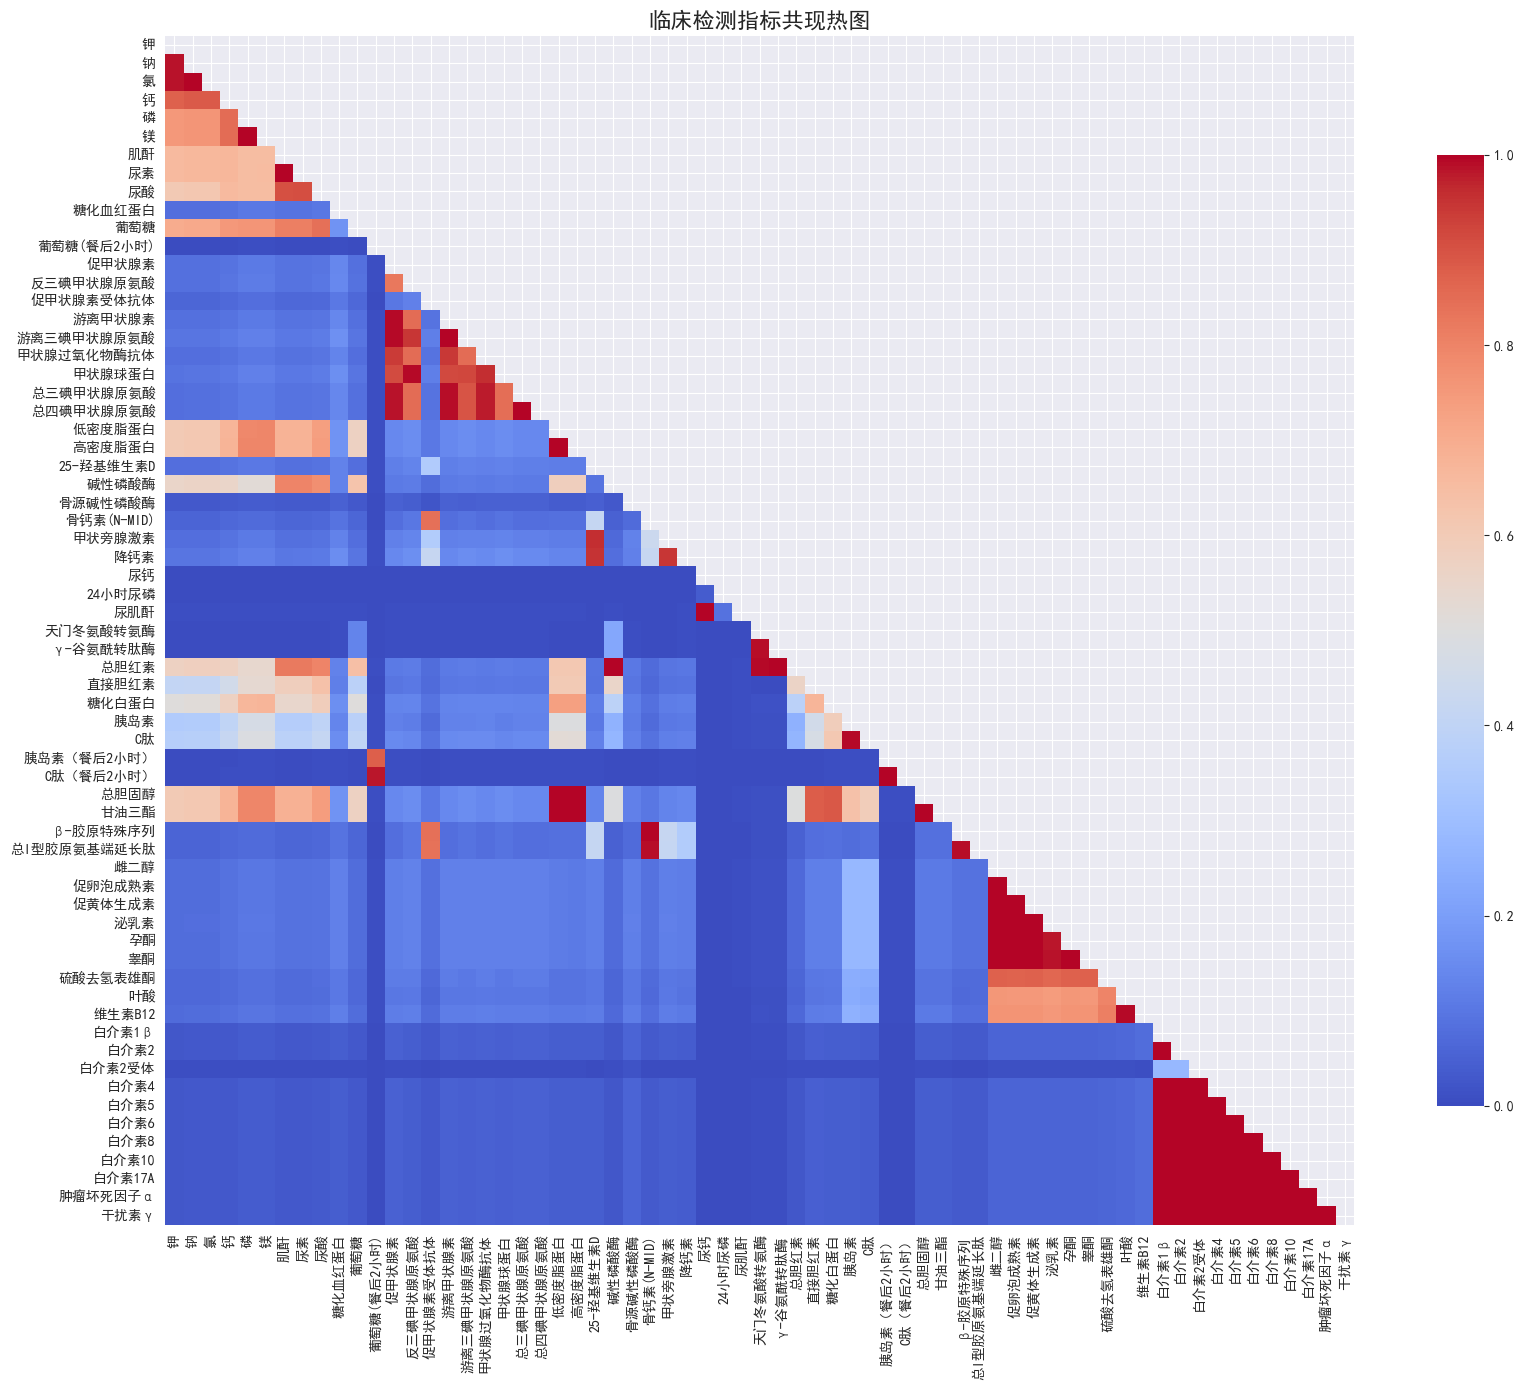

[({'γ-谷氨酰转肽酶',
   '低密度脂蛋白',
   '天门冬氨酸转氨酶',
   '尿素',
   '尿酸',
   '总胆固醇',
   '总胆红素',
   '氯',
   '甘油三酯',
   '直接胆红素',
   '碱性磷酸酶',
   '磷',
   '糖化白蛋白',
   '肌酐',
   '葡萄糖',
   '钙',
   '钠',
   '钾',
   '镁',
   '高密度脂蛋白'},
  0.4789473684210526),
 ({'C肽（餐后2小时）', '胰岛素（餐后2小时）', '葡萄糖(餐后2小时)'}, 1.0),
 ({'促甲状腺素',
   '反三碘甲状腺原氨酸',
   '总三碘甲状腺原氨酸',
   '总四碘甲状腺原氨酸',
   '游离三碘甲状腺原氨酸',
   '游离甲状腺素',
   '甲状腺球蛋白',
   '甲状腺过氧化物酶抗体'},
  1.0),
 ({'β-胶原特殊序列', '促甲状腺素受体抗体', '总I型胶原氨基端延长肽', '骨钙素(N-MID)'}, 1.0),
 ({'25-羟基维生素D', '甲状旁腺激素', '降钙素'}, 1.0),
 ({'C肽', '胰岛素'}, 1.0),
 ({'促卵泡成熟素', '促黄体生成素', '叶酸', '孕酮', '泌乳素', '睾酮', '硫酸去氢表雄酮', '雌二醇'}, 1.0),
 ({'干扰素γ',
   '白介素10',
   '白介素17A',
   '白介素1β',
   '白介素2',
   '白介素2受体',
   '白介素4',
   '白介素5',
   '白介素6',
   '白介素8',
   '肿瘤坏死因子α'},
  0.8545454545454545)]

In [12]:
# 计算共现占比矩阵
co_occurrence = value_data.notnull().astype(int).T.dot(value_data.notnull().astype(int))
co_occurrence_ratio = co_occurrence.div(value_data.notnull().sum(axis=0), axis=1)

# 画热图
plt.figure(figsize=(18, 14))
sns.heatmap(co_occurrence_ratio, cmap='coolwarm', annot=False, fmt="d", square=True,
            mask=np.triu(np.ones(co_occurrence_ratio.shape, dtype=bool)), cbar_kws={"shrink": .8})
plt.title("临床检测指标共现热图", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 筛选共现占比大于0.8且共现次数大于100的对
co_occurrence_pairs = []
for i in range(co_occurrence.shape[0]):
    for j in range(i + 1, co_occurrence.shape[1]):
        if co_occurrence.iloc[i, j] > 100 and co_occurrence_ratio.iloc[i, j] > 0.8:
            co_occurrence_pairs.append((co_occurrence.index[i], co_occurrence.columns[j]))

corr_graph = nx.Graph()
corr_graph.add_edges_from(co_occurrence_pairs)
corr_connected_components = list(nx.connected_components(corr_graph))

# 计算每个连通块的子图密度
component_densities = [
    (component, nx.density(corr_graph.subgraph(component)))
    for component in corr_connected_components
]

component_densities

第一个连通块有点稀疏，我们用社区检测算法来进一步将其划分为无重叠的子图。

In [13]:
sparse_component = corr_connected_components[0]

# 使用社区检测算法
communities = list(greedy_modularity_communities(corr_graph.subgraph(sparse_component)))

# 附加每个社区的子图密度
community_densities = [
    (community, nx.density(corr_graph.subgraph(community)))
    for community in communities
]

community_densities

[(frozenset({'低密度脂蛋白', '总胆固醇', '甘油三酯', '磷', '糖化白蛋白', '葡萄糖', '镁', '高密度脂蛋白'}),
  0.8571428571428571),
 (frozenset({'尿素', '尿酸', '氯', '肌酐', '钙', '钠', '钾'}), 1.0),
 (frozenset({'γ-谷氨酰转肽酶', '天门冬氨酸转氨酶', '总胆红素', '直接胆红素', '碱性磷酸酶'}), 0.6)]

到此为止，整个数据集的数值特征已经被分为以下部分，其中每一个似乎都是针对某一类疾病的相关指标，具有一定临床意义。

1. 餐后耐糖/胰岛素
2. 甲状腺功能
3. 骨形成/TRAb，TRAb是骨代谢检查的病因筛查拓展项
4. 血钙-骨代谢调节轴的核心三激素
5. 空腹胰岛素释放
6. 生殖／性激素
7. 免疫／炎症因子
8. 代谢综合征
9. 肾功能
10. 肝胆功能

还剩下一些没有被分组的特征，它们可能和其它特征关系没有那么密切，或者是相对独立的特征。我们可以计算它们与其他特征的共现频次，手动处理这些特征。

In [22]:
groups = [['C肽（餐后2小时）', '胰岛素（餐后2小时）', '葡萄糖(餐后2小时)'],
          ['促甲状腺素', '反三碘甲状腺原氨酸', '总三碘甲状腺原氨酸', '总四碘甲状腺原氨酸', '游离三碘甲状腺原氨酸',
           '游离甲状腺素', '甲状腺球蛋白', '甲状腺过氧化物酶抗体'],
          ['β-胶原特殊序列', '促甲状腺素受体抗体', '总I型胶原氨基端延长肽', '骨钙素(N-MID)'],
          ['25-羟基维生素D', '甲状旁腺激素', '降钙素'],
          ['C肽', '胰岛素'],
          ['促卵泡成熟素', '促黄体生成素', '叶酸', '孕酮', '泌乳素', '睾酮', '硫酸去氢表雄酮', '雌二醇'],
          ['干扰素γ', '白介素10', '白介素17A', '白介素1β', '白介素2', '白介素2受体', '白介素4', '白介素5', '白介素6',
           '白介素8', '肿瘤坏死因子α'],
          ['低密度脂蛋白', '总胆固醇', '甘油三酯', '磷', '糖化白蛋白', '葡萄糖', '镁', '高密度脂蛋白'],
          ['尿素', '尿酸', '氯', '肌酐', '钙', '钠', '钾'],
          ['γ-谷氨酰转肽酶', '天门冬氨酸转氨酶', '总胆红素', '直接胆红素', '碱性磷酸酶']]

all_features = set(value_data.columns)

grouped_features = set(feature for group in groups for feature in group)

# 找出未涉及的特征
ungrouped_features = all_features - grouped_features

# 计算每个 ungrouped_feature 与其他特征的共同出现频次
ungrouped_feature_co_occurrence = {}

for feature in ungrouped_features:
    co_occurrence_counts = value_data.notnull().astype(int).T.dot(value_data[feature].notnull().astype(int))
    co_occurrence_counts = co_occurrence_counts.sort_values(ascending=False)
    ungrouped_feature_co_occurrence[feature] = co_occurrence_counts

ungrouped_feature_co_occurrence_df = pd.DataFrame.from_dict(
    {feature: counts for feature, counts in ungrouped_feature_co_occurrence.items()},
    orient='index'
).fillna(0)

ungrouped_feature_co_occurrence_df = ungrouped_feature_co_occurrence_df.stack().reset_index()
ungrouped_feature_co_occurrence_df.columns = ['Feature1', 'Feature2', 'Frequency']
ungrouped_feature_co_occurrence_df = ungrouped_feature_co_occurrence_df.sort_values(by=['Feature1', 'Frequency'],
                                                                                    ascending=False)

ungrouped_feature_co_occurrence_df

,Feature1,Feature2,Frequency
386,骨源碱性磷酸酶,骨源碱性磷酸酶,979
328,骨源碱性磷酸酶,钙,137
329,骨源碱性磷酸酶,钾,137
331,骨源碱性磷酸酶,钠,137
332,骨源碱性磷酸酶,氯,137
...,...,...,...
255,24小时尿磷,白介素8,0
256,24小时尿磷,骨源碱性磷酸酶,0
257,24小时尿磷,天门冬氨酸转氨酶,0
258,24小时尿磷,γ-谷氨酰转肽酶,0


我们发现骨源碱性磷酸酶和糖化血红蛋白偏向于独立，和其它指标共现的频次都相当；维生素B12和性激素共现最多，我们认为它可以纳入性激素面板；尿钙、尿肌酐、24小时尿磷三者显然组成了尿常规检查面板，因为样本数太少它在第一次分组中被剔除了，我们可以手动加上它们。结果如下：


| 检测分类    | 检测项目                                                                                              | 检测内容标题     |
|---------|---------------------------------------------------------------------------------------------------|------------|
| 血糖血脂相关  | ('C肽（餐后2小时）', '胰岛素（餐后2小时）', '葡萄糖(餐后2小时)')                                                         | 餐后血糖调节     |
|         | ('C肽', '胰岛素')                                                                                     | 空腹胰岛素分泌    |
|         | ('糖化血红蛋白',)                                                                                       | 糖尿病监测      |
|         | ('低密度脂蛋白', '总胆固醇', '甘油三酯', '磷', '糖化白蛋白', '葡萄糖', '镁', '高密度脂蛋白')                                    | 血脂和基础代谢评估  |
| 肾功能相关   | ('尿素', '尿酸', '氯', '肌酐', '钙', '钠', '钾')                                                            | 肾功能及电解质评估  |
|         | ('尿肌酐', '尿钙', '24小时尿磷')                                                                           | 肾功能及钙磷代谢评估 |
| 骨代谢相关   | ('β-胶原特殊序列', '促甲状腺素受体抗体', '总I型胶原氨基端延长肽', '骨钙素(N-MID)')                                            | 骨形成与甲状腺排查  |
|         | ('25-羟基维生素D', '甲状旁腺激素', '降钙素')                                                                    | 血钙-骨代谢调节评估 |
|         | ('骨源碱性磷酸酶',)                                                                                      | 骨形成标志物     |
| 产科相关    | ('促卵泡成熟素', '促黄体生成素', '叶酸', '孕酮', '泌乳素', '睾酮', '硫酸去氢表雄酮', '雌二醇', '维生素B12')                         | 性激素水平与营养评估 |
| 甲状腺相关   | ('促甲状腺素', '反三碘甲状腺原氨酸', '总三碘甲状腺原氨酸', '总四碘甲状腺原氨酸', '游离三碘甲状腺原氨酸', '游离甲状腺素', '甲状腺球蛋白', '甲状腺过氧化物酶抗体')  | 甲状腺功能评估    |
| 免疫/炎症相关 | ('干扰素γ', '白介素10', '白介素17A', '白介素1β', '白介素2', '白介素2受体', '白介素4', '白介素5', '白介素6', '白介素8', '肿瘤坏死因子α') | 炎症因子监测     |
| 肝功能相关   | ('γ-谷氨酰转肽酶', '天门冬氨酸转氨酶', '总胆红素', '直接胆红素', '碱性磷酸酶')                                                | 肝酶及胆红素代谢   |



画相关度矩阵热力图来进行特征的相关度分析，尝试找到特征之间的隐藏联系。我们会重点观察相关性在0.6以上的特征对，包括反相关。

原数据十分稀疏，有的特征对相关性甚至算不出来，因为它们从没有一起出现过；有的能算出来，但是因为数据量太少，相关性不可靠。因此我们只考虑非空数据行数大于100的特征对。

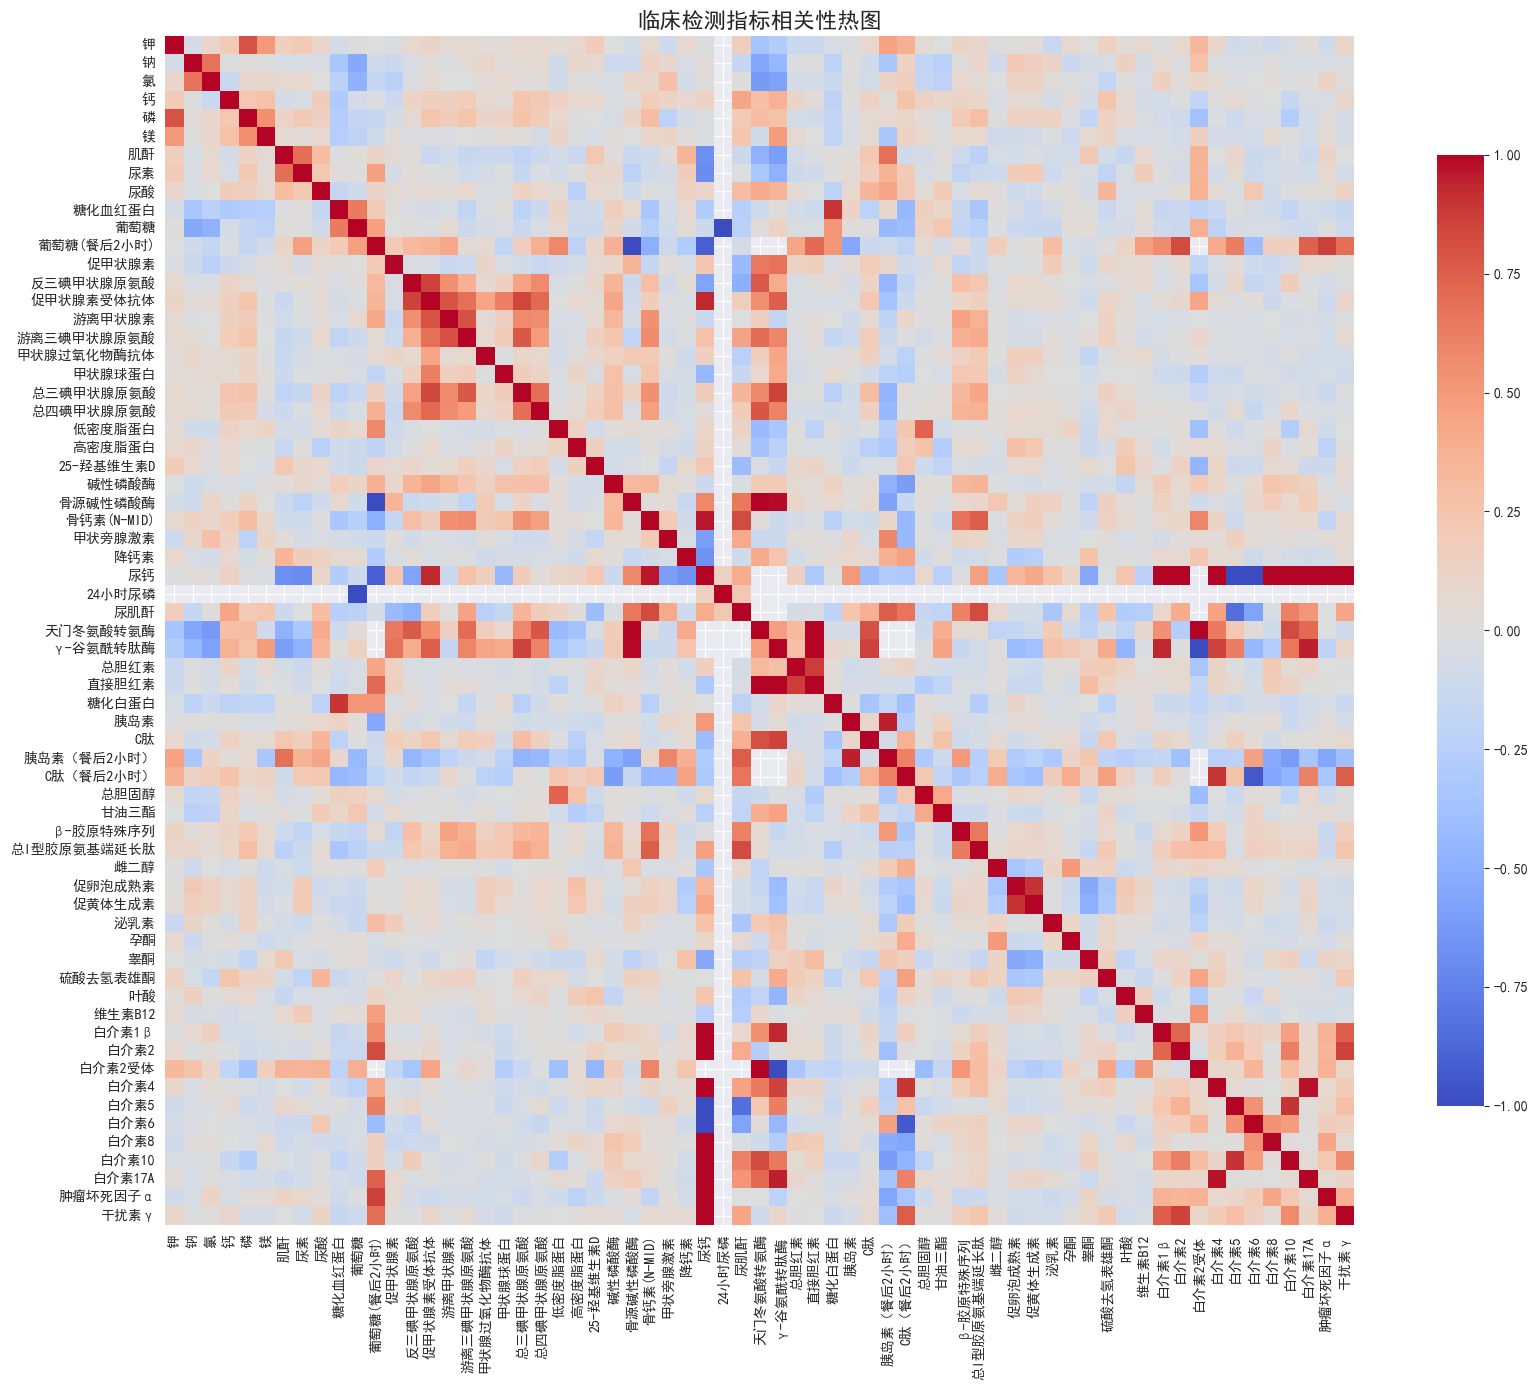

,,相关性,非空数据行数
白介素4,白介素17A,0.969093,685
白介素5,白介素10,0.904059,685
促卵泡成熟素,促黄体生成素,0.901938,2261
糖化血红蛋白,糖化白蛋白,0.896000,349
总胆红素,直接胆红素,0.869692,2138
白介素2,干扰素γ,0.857367,685
反三碘甲状腺原氨酸,促甲状腺素受体抗体,0.856034,304
促甲状腺素受体抗体,总三碘甲状腺原氨酸,0.837337,252
游离甲状腺素,游离三碘甲状腺原氨酸,0.806326,2545
钾,磷,0.797014,3513


In [25]:
# 计算相关性矩阵
corr = value_data.corr(method='pearson')

# 画热图
plt.figure(figsize=(18, 14))
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt=".2f", square=True,
            mask=corr.isnull(), cbar_kws={"shrink": .8})
plt.title("临床检测指标相关性热图", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 上三角矩阵索引
upper_tri = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# 找出绝对值大于0.6的列对
high_corr_pairs = upper_tri.stack().sort_values(ascending=False)
high_corr_pairs = high_corr_pairs[abs(high_corr_pairs) > 0.6]

# 计算相关性来源的非空数据行数
non_null_counts = {
    (col1, col2): value_data[[col1, col2]].dropna().shape[0]
    for col1, col2 in high_corr_pairs.index
}

# 将相关性和非空数据行数一起显示，并筛掉数据来源少于 100 个的
high_corr_pairs = high_corr_pairs.to_frame('相关性')
high_corr_pairs['非空数据行数'] = [
    non_null_counts[(col1, col2)] for col1, col2 in high_corr_pairs.index
]
high_corr_pairs = high_corr_pairs[high_corr_pairs['非空数据行数'] >= 100]

high_corr_pairs

In [16]:
# 构建图并提取连通块
corr_graph = nx.Graph()
corr_graph.add_edges_from(high_corr_pairs.index)  # 使用相关对作为边
corr_connected_components = list(nx.connected_components(corr_graph))  # 获取连通块

# 输出连通块
corr_connected_components

[{'白介素17A', '白介素4'},
 {'干扰素γ', '白介素10', '白介素1β', '白介素2', '白介素5'},
 {'促卵泡成熟素', '促黄体生成素'},
 {'糖化白蛋白', '糖化血红蛋白', '葡萄糖'},
 {'总胆红素', '直接胆红素'},
 {'促甲状腺素受体抗体',
  '反三碘甲状腺原氨酸',
  '总三碘甲状腺原氨酸',
  '总四碘甲状腺原氨酸',
  '游离三碘甲状腺原氨酸',
  '游离甲状腺素',
  '甲状腺球蛋白'},
 {'磷', '钾'},
 {'β-胶原特殊序列', '总I型胶原氨基端延长肽', '骨钙素(N-MID)'},
 {'低密度脂蛋白', '总胆固醇'},
 {'尿素', '肌酐'},
 {'氯', '钠'},
 {'C肽（餐后2小时）', '胰岛素（餐后2小时）'}]

每一组内的特征之间具有相关性，虽然不是完全相关，比如违反相关性的数据有可能是某些疾病导致的反常，但是这些分组仍然可解释。

1. 免疫和过敏反应
2. 炎症反应
3. 性腺功能
4. 糖代谢
5. 总体和部分的关系，确实应该相关
6. 甲状腺功能
7. 酸碱平衡，肾功能相关
8. 骨代谢
9. 总体和部分的关系
10. 反应肾小球滤过率
11. 共同维持血浆渗透压
12. 胰岛功能